In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [1]:
!pip install datasets transformers albumentations huggingface_hub

In [2]:
from datasets import load_dataset

dataset = load_dataset("jaygala223/38-cloud-train-only-v2")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/8400 [00:00<?, ? examples/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8400
    })
})

In [4]:
# shuffle + split dataset
dataset = dataset.shuffle(seed=1)
dataset = dataset["train"].train_test_split(test_size=0.1)
train_ds = dataset["train"]
test_ds = dataset["test"]

In [5]:
print(train_ds)
print(test_ds)

Dataset({
    features: ['image', 'label'],
    num_rows: 7560
})
Dataset({
    features: ['image', 'label'],
    num_rows: 840
})


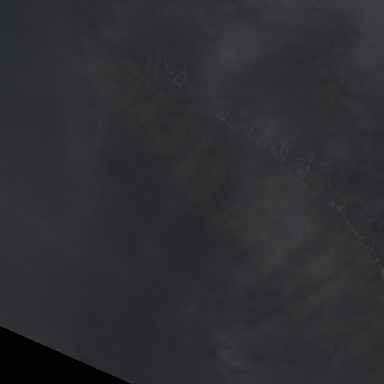

In [ ]:
# let's look at one example (images are pretty high resolution)
example = train_ds[839]
image = example['image']
image

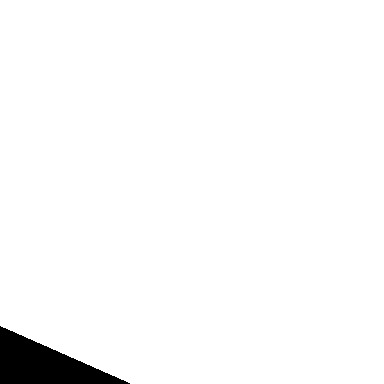

In [ ]:
label = example['label']
label

In [ ]:
import numpy as np
np.array(image).shape

(384, 384, 3)

In [ ]:
import numpy as np

# load corresponding ground truth segmentation map, which includes a label per pixel
segmentation_map = np.array(example['label'])/255
segmentation_map = np.array(segmentation_map, dtype=np.uint8)
segmentation_map

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

In [ ]:
np.unique(segmentation_map)

array([0, 1], dtype=uint8)

In [6]:
from huggingface_hub import hf_hub_download
import json

repo_id = f"jaygala223/38-cloud-train-only-v2"
filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
id2label = {int(k):v for k,v in id2label.items()}
print(id2label)

{0: 'non-cloud', 1: 'cloud'}


In [ ]:
# def color_palette():
#     """Color palette that maps each class to RGB values.

#     This one is actually taken from ADE20k.
#     """

#     #since we only have 2 classes
#     return [[102, 255, 0], [92, 0, 255]]

# palette = color_palette()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
# for label, color in enumerate(palette):
#     color_segmentation_map[segmentation_map == label, :] = color
# # Convert to BGR
# ground_truth_color_seg = color_segmentation_map[..., ::-1]

# img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
# img = img.astype(np.uint8)

# plt.figure(figsize=(15, 10))
# plt.imshow(img)
# plt.show()

In [7]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['image'])
        original_segmentation_map = np.array(self.dataset[idx]['label'])

        # adding one bottom most pixel as 255 since processor/feature_extractor
        # wont take labels without a positive (i.e. class: 1 or cloud)
        uniques = np.unique(original_segmentation_map)
        if sum(uniques) == 0:
            original_segmentation_map[-1, -1] = 255

        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, segmentation_map = transformed['image'], transformed['mask']

        # convert to C, H, W
        image = image.transpose(2,0,1)

        return image, segmentation_map, original_image, original_segmentation_map

In [8]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

train_transform = A.Compose([
    # A.LongestMaxSize(max_size=384),
    # A.RandomCrop(width=100, height=100),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

test_transform = A.Compose([
    # A.Resize(width=100, height=100),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])
# train_dataset = ImageSegmentationDataset(train_ds)
train_dataset = ImageSegmentationDataset(train_ds, transform=train_transform)
test_dataset = ImageSegmentationDataset(test_ds, transform=test_transform)
# test_dataset = ImageSegmentationDataset(test_ds)

In [ ]:
# image, segmentation_map, _, _ = train_dataset[0]
image, segmentation_map, _, _ = train_dataset[222]
print(image.shape)
print(segmentation_map.shape)

(3, 384, 384)
(384, 384)


In [9]:
from transformers import MaskFormerImageProcessor,Mask2FormerImageProcessor, AutoImageProcessor

# Create a preprocessor
# preprocessor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-tiny-ade-semantic",
#                                                   do_reduce_labels=False,
#                                                   do_resize=False, do_rescale=False, do_normalize=False)

size = {'longest_edge':384, 'shortest_edge':384}

#original
preprocessor = Mask2FormerImageProcessor(ignore_index=0,
                                        do_reduce_labels=False,
                                        do_resize=False,
                                        do_rescale=False,
                                        do_normalize=True,
                                        size=size)

#my experiment
# preprocessor = Mask2FormerImageProcessor(ignore_index=0, do_reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [10]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]

    return batch

In [11]:

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# batch size more than 4 causes CUDA out of memory error

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, drop_last=True)

In [12]:
import torch

batch = next(iter(train_dataloader))

for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([1, 3, 384, 384])
pixel_mask torch.Size([1, 384, 384])
mask_labels torch.Size([1, 384, 384])
class_labels torch.Size([1])
original_images (384, 384, 3)
original_segmentation_maps (384, 384)


In [ ]:
# from transformers import MaskFormerForInstanceSegmentation, Mask2FormerForUniversalSegmentation

# Replace the head of the pre-trained model

# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-IN21k-ade-semantic",
#                                                             id2label=id2label,
#                                                             ignore_mismatched_sizes=True)


# from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

# feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b3-finetuned-ade-512-512")
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b3-finetuned-ade-512-512")

# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-ade-semantic",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

# model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

# finetuned_model = MaskFormerForInstanceSegmentation.from_pretrained("jaygala223/maskformer-finetuned-for-38-cloud-dataset",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

In [ ]:
# from transformers import MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation, AutoImageProcessor, UperNetForSemanticSegmentation
# from PIL import Image
# import requests

# size = {'longest_edge':384, 'shortest_edge':383}

# load MaskFormer fine-tuned on COCO panoptic segmentation
# feature_extractor = Mask2FormerFeatureExtractor.from_pretrained("facebook/maskformer-swin-base-ade",
#                                                                size=size,
#                                                                )

# model 1 is for generating new pred segmentation maps... model 2 is to train on new pred labels

# image_processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-swin-tiny")
# image_processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-swin-tiny")

# model = UperNetForSemanticSegmentation.from_pretrained("jaygala223/upernet-swin-tiny-finetuned-for-38-cloud-dataset")
# model = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-swin-base")
# model = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-swin-tiny")

# model = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-swin-tiny")

# load MaskFormer fine-tuned on COCO panoptic segmentation
# feature_extractor = MaskFormerFeatureExtractor.from_pretrained("facebook/maskformer-swin-base-ade",
#                                                                size={'longest_edge':384, 'shortest_edge':383},
#                                                                )

In [ ]:
# from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation
# from PIL import Image
# import requests

# image_processor = AutoImageProcessor.from_pretrained("google/deeplabv3_mobilenet_v2_1.0_513")
# model = AutoModelForSemanticSegmentation.from_pretrained("google/deeplabv3_mobilenet_v2_1.0_513")

In [13]:
import torch

def binarize_image(image, threshold = 50):
    """
    Binarizes a color image.

    Args:
        image (torch.Tensor): Input color image of shape [1, H, W, 3].
        threshold (float): Threshold value for binarization (between 0 and 255).

    Returns:
        torch.Tensor: Binarized image of shape [1, H, W].
    """
    image = image.float()
    # Convert the image to grayscale by taking the average across color channels
    gray_image = torch.mean(image, dim=3, keepdim=True)  # Shape: [1, H, W, 1]

    # Apply binarization based on the threshold
    binary_image = torch.where(gray_image >= threshold, torch.ones_like(gray_image), torch.zeros_like(gray_image))

    return binary_image.squeeze(dim=3)

In [14]:
import torch

def binarize_image_learnable(image, threshold):
    """
    Binarizes a color image.

    Args:
        image (torch.Tensor): Input color image of shape [1, H, W, 3].
        threshold (float): Threshold value for binarization (between 0 and 255).

    Returns:
        torch.Tensor: Binarized image of shape [1, H, W].
    """
    image = image.float()
    alpha = 1
#     threshold = torch.clamp(threshold,min=0.0, max=1.0)
    threshold_l = 255*(0.55 - alpha*torch.sigmoid(threshold))
    print(threshold)

    # Convert the image to grayscale by taking the average across color channels
    gray_image = torch.mean(image, dim=3, keepdim=True)  # Shape: [1, H, W, 1]

    # Apply binarization based on the threshold
    binary_image = torch.where(gray_image >= threshold_l, torch.ones_like(gray_image), torch.zeros_like(gray_image))
    print(threshold.grad,binary_image.grad)
    return binary_image.squeeze(dim=3)

In [ ]:
# import torch
# import torch.nn as nn

# class ThresholdModule(nn.Module):
#     def __init__(self):
#         super(ThresholdModule, self).__init__()
#         # Define a fully connected layer to learn the threshold value
#         self.fc = nn.Linear(3 * 384 * 384, 1)  # Input size is flattened image
#         # Initialize the threshold value to a reasonable starting point
#         nn.init.constant_(self.fc.weight, 0.5)  # You can adjust the initial value as needed

#     def forward(self, x):
#         # Flatten the input image
#         x = x.view(x.size(0), -1)
#         # Ensure that the data type matches (e.g., float32)
#         x = x.to(self.fc.weight.dtype)
#         # Apply the threshold module
#         threshold = torch.sigmoid(self.fc(x))  # Apply sigmoid to ensure it's in [0, 1]
#         return threshold

In [ ]:
# threshold_module = ThresholdModule()
# threshold_module.to(device)
# threshold = threshold_module(images.to(device))
# threshold.item()

NameError: name 'device' is not defined

In [ ]:
def maskformer_forward_pass(model, feature_extractor, images, labels, device):
    inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')

    inputs['pixel_values'] = inputs['pixel_values'].float()

    inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
    inputs['class_labels'] = torch.stack(inputs['class_labels'])

    inputs.to(device)

    outputs = model(**inputs)

    return outputs

In [ ]:
def upernet_forward_pass(model, image_processor, images, labels, device):
    inputs = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')
    inputs.to(device)

    outputs = model(**inputs)

    return outputs

In [ ]:
from torchvision.transforms import ToPILImage
import PIL.Image as Image

def display_tensor_as_pil(tensor):
    tensor = (tensor * 255).byte()

    # Convert the PyTorch tensor to a PIL image
    to_pil = ToPILImage()
    pil_image = to_pil(tensor)

    return pil_image

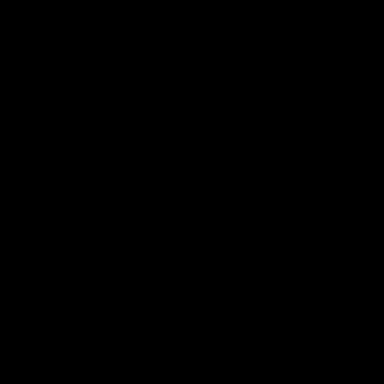

In [ ]:
# display_tensor_as_pil(images.permute(0, 3, 1, 2)[0]/255)

tensor(1)


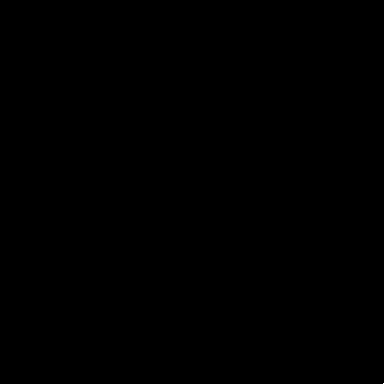

In [ ]:
# print(torch.sum(labels == 1))

# display_tensor_as_pil(labels)

tensor(0)


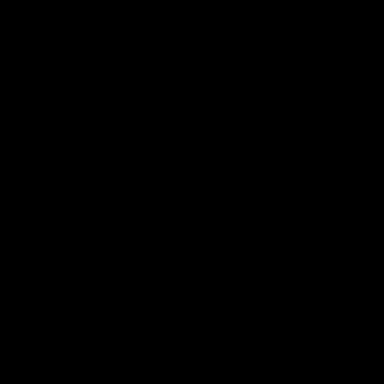

In [ ]:
# print(torch.sum(new_labels == 1))

# display_tensor_as_pil(new_labels)

In [ ]:
# torch.sum(labels == 1).item()

1

In [31]:
import torch
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [15]:
def unet_forward_pass(model, images, device):
    model.to(device)
    images.to(device)

    outputs = model(images.float().permute(0,3,1,2))
    # outputs = (outputs > 0).float()
    return outputs

In [20]:
device = "cpu"

batch = next(iter(train_dataloader))

# model = torch.load()

images, labels = batch['original_images'], batch['original_segmentation_maps']

# first convert to np array then to tensor... because list to tensor is a slow operation
images = np.array(images)
images = torch.tensor(images)
labels = np.array(labels)
labels = torch.tensor(labels)/255

# print(images.shape)

images.to(device)
labels.to(device)
model.to(device)

new_labels = binarize_image(images, threshold=55)

# if there is only single cloud (i.e. 1) pixel then leave it
# or if all elements in new_labels are 1 then leave it (because image may have SNOW)
# note: binarization does poorly on snowy images.
# if (labels == 1).all().item() == 1 or (labels == 0).all().item() == 1:
#     new_labels = labels

outputs = unet_forward_pass(model, images.to(device), device)

# outputs = upernet_forward_pass(model, image_processor,images, labels, device)

print("done!")

done!


In [22]:
outputs

tensor([[[[0.4198, 0.6498, 0.8036,  ..., 0.4449, 0.4303, 0.4396],
          [0.3800, 0.7409, 0.8780,  ..., 0.4083, 0.5112, 0.3958],
          [0.4958, 0.8806, 0.7893,  ..., 0.5354, 0.4316, 0.4160],
          ...,
          [0.5621, 0.7817, 0.8582,  ..., 0.4824, 0.4292, 0.5398],
          [0.4616, 0.8402, 0.7389,  ..., 0.5276, 0.4945, 0.4567],
          [0.2825, 0.4636, 0.6494,  ..., 0.5044, 0.5155, 0.4654]]]],
       grad_fn=<SigmoidBackward0>)

In [21]:
outputs.shape, labels.unsqueeze(dim=1).shape

(torch.Size([1, 1, 384, 384]), torch.Size([1, 1, 384, 384]))

TRAINING

In [ ]:
# model=torch.load('unet_checkpoint_44_iou.pth')

In [26]:
def calculate_iou(pred_mask_list, true_mask_list):
    total_iou = 0.0
    num_masks = len(pred_mask_list)

    for pred_mask, true_mask in zip(pred_mask_list, true_mask_list):
        pred_mask = pred_mask.cpu()
        true_mask = true_mask.cpu()
        intersection = torch.logical_and(pred_mask, true_mask).sum()
        union = torch.logical_or(pred_mask, true_mask).sum()

        iou = intersection.float() / union.float()
        total_iou += iou.item()

    avg_iou = total_iou / num_masks
    return avg_iou

In [29]:
import torch

def calculate_metrics(true_labels, predicted_labels, device):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    for true, predicted in zip(true_labels, predicted_labels):
        true.to(device)
        predicted.to(device)
        true_positives += torch.sum((predicted == 1) & (true == 1)).item()
        false_positives += torch.sum((predicted == 1) & (true == 0)).item()
        false_negatives += torch.sum((predicted == 0) & (true == 1)).item()
        true_negatives += torch.sum((predicted == 0) & (true == 0)).item()

    precision = true_positives / (true_positives + false_positives + 1e-7)
    recall = true_positives / (true_positives + false_negatives + 1e-7)
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)

    return precision, recall, accuracy, f1_score

# Example usage
true_labels = [torch.tensor([1, 0, 1]), torch.tensor([1, 1, 0])]
predicted_labels = [torch.tensor([1, 0, 1]), torch.tensor([1, 1, 0])]

precision, recall, accuracy, f1_score = calculate_metrics(true_labels, predicted_labels, "cpu")
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

Precision: 0.9999999750000006
Recall: 0.9999999750000006
Accuracy: 0.9999999833333336
F1 Score: 0.9999999250000032


In [28]:
def calculate_iou_from_tensors(predicted, target):
    """
    Calculate Intersection over Union (IoU) between two tensors.

    Args:
        predicted (torch.Tensor): Predicted binary tensor.
        target (torch.Tensor): Ground truth binary tensor.

    Returns:
        float: Intersection over Union (IoU) score.
    """
    intersection = torch.logical_and(predicted, target).sum()
    union = torch.logical_or(predicted, target).sum()
    iou = float(intersection) / float(union + 1e-6)  # Add a small epsilon to avoid division by zero
    return iou

In [33]:
# BINARIZATION TRAINING

import torch
from tqdm.auto import tqdm
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# threshold_module = ThresholdModule()

criterion = nn.BCEWithLogitsLoss()

model_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

learnable_threshold = 55
delta_x = 1
best_loss = float('inf')

running_loss = 0.0
num_samples = 0
batch_size = 1

update_frequency = 50

for epoch in range(50):
  print("Epoch:", epoch)
  model.train()
  if_condition = 0
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      model_optimizer.zero_grad()
      torch.cuda.empty_cache()

      images, labels = batch['original_images'], batch['original_segmentation_maps']

      images = np.array(images)
      images = torch.tensor(images)
      labels = np.array(labels)
      labels = torch.tensor(labels)/255

      images.to(device)
      labels.to(device)
      model.to(device)
#       threshold_module.to(device)

#       threshold = threshold_module(images.to(device))

#       new_labels = binarize_image(images, threshold=55)
      new_labels = binarize_image(images, threshold=learnable_threshold)
#       print()

      # if there is only single cloud (i.e. 1) pixel then leave it
      # or if all elements in new_labels are 1 then leave it (because image may have SNOW)
      # note: binarization does poorly on snowy images.
#       if (labels == 1).all().item() == 1 or torch.sum(labels).item() < 10:
#           new_labels = labels
#           if_condition += 1

      outputs = unet_forward_pass(model.to(device), images.to(device), device)
      # Backward propagation
      loss = criterion(outputs.float().to(device), new_labels.float().unsqueeze(dim=1).to(device))
      # loss = torch.autograd.Variable(loss, requires_grad = True)

      if loss.item() < best_loss:
            best_loss = loss.item()

      if (idx + 1) % update_frequency == 0:
          # Adjust the threshold every 'update_frequency' iterations
          if loss.item() > best_loss:
              learnable_threshold -= delta_x  # Decrease the threshold
          else:
              learnable_threshold += delta_x  # Increase the threshold

      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 1 == 0:
        print("Loss:", running_loss/num_samples)
        print("threshold value", learnable_threshold)
#         print("Threshold: ", threshold.item())
#         print(f"if_condition executed {if_condition} times")

      # Optimization
      model_optimizer.step()

#   model.eval()
#   device = "cuda"
#   all_ious = []
#   precisions, recalls, accuracies, f1_scores = [], [], [], []
#   for idx, batch in enumerate(tqdm(test_dataloader)):
#       if idx > 100:
#           break
#       images, labels = batch['original_images'], batch['original_segmentation_maps']

#       images = np.array(images)
#       images = torch.tensor(images)
#       labels = np.array(labels)
#       labels = torch.tensor(labels)/255

#       images.to(device)
#       labels.to(device)
#       model.to(device)

#   #     inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')
#   # #     print(inputs)

#   #     ##### comment these 2 lines for segformer... keep otherwise ####
#   #     inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
#   #     inputs['class_labels'] = torch.stack(inputs['class_labels'])
#   #     ##### comment these 2 lines for segformer... keep otherwise ####


#   #     inputs['pixel_values'] = inputs['pixel_values'].float()
#   #     inputs.to(device)

#       # Forward pass
#       with torch.no_grad():
#         # outputs = model(pixel_values=pixel_values.to(device))
#   #       threshold = threshold_module(images.to(device))

#         new_labels = binarize_image(images, threshold=55)


#       # if there is only single cloud (i.e. 1) pixel then leave it
#       # or if all elements in new_labels are 1 then leave it (because image may have SNOW)
#       # note: binarization does poorly on snowy images.
# #       if (labels == 1).all().item() == 1 or torch.sum(labels).item() < 10:
# #           new_labels = labels
# #           if_condition += 1

#         outputs = unet_forward_pass(model.to(device), images.to(device), device)
#         outputs = torch.round(outputs)
#     #   print(outputs, labels)



#     # get original images
#     # original_images = batch["original_images"]
#     # target_sizes = [(image.shape[0], image.shape[1]) for image in images]
#     # predict segmentation maps
#     # predicted_segmentation_maps = image_processor.post_process_semantic_segmentation(outputs,
#                                                                                 #   target_sizes=target_sizes)


#     # for preds in outputs:
#     #     preds.int()
#     #     preds.to(device)
#     #     preds.to(device)
#     # for label in labels:
#     #     label.int()
#     #     label.to(device)

#     #for mean iou calculation... pred maps and labels must be same shape
#     # labels_list = []

#     # for i in range(labels.size(0)):
#     #     labels[i].int()
#     #     labels[i].to(device)
#     #     labels_list.append(labels[i].to(device))

# #     print(predicted_segmentation_maps, labels_list)
#       all_ious.append(calculate_iou_from_tensors(outputs.to(device), new_labels.unsqueeze(dim=1).to(device)))
#       precision, recall, accuracy, f1_score = calculate_metrics(new_labels.unsqueeze(dim=1).to(device), outputs.to(device), device)
#       precisions.append(precision)
#       recalls.append(recall)
#       accuracies.append(accuracy)
#       f1_scores.append(f1_score)
#   print("TESTING NOW:\nprecision:", sum(precisions)/ len(precisions))
#   print("f1_score:", sum(f1_scores)/ len(f1_scores))
#   print("recall:", sum(recalls)/ len(recalls))
#   print("accuracy:", sum(accuracies)/ len(accuracies))
#   print("mIoU: ", sum(all_ious)/len(all_ious))

Epoch: 0


  0%|          | 0/7560 [00:00<?, ?it/s]

Loss: 0.9499077200889587
threshold value 55
Loss: 0.9257221817970276
threshold value 55
Loss: 0.9138208429018656
threshold value 55
Loss: 0.8210565000772476
threshold value 55
Loss: 0.8383759379386901
threshold value 55
Loss: 0.8143925468126932
threshold value 55
Loss: 0.8236768926892962
threshold value 55
Loss: 0.7845476791262627
threshold value 55


KeyboardInterrupt: ignored

In [25]:
learnable_threshold

21.0

In [ ]:
# BINARIZATION TRAINING

import torch
from tqdm.auto import tqdm
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# threshold_module = ThresholdModule()

criterion = nn.BCEWithLogitsLoss()
criterion_thres = nn.MSELoss()

l_thres = nn.Parameter(torch.randn((1,1)),requires_grad=True)
print("before loop", l_thres)
# [{'params': pretrained_model.parameters()}, {'params': threshold}]
model_optimizer = torch.optim.Adam([{'params': model.parameters()},{'params': l_thres}], lr=1e-3)

running_loss = 0.0
num_samples = 0
batch_size = 4
# thres = torch.sigmoid(0.55 - learnable(x))


for epoch in range(50):
  print("Epoch:", epoch)
  model.train()
  if_condition = 0
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      model_optimizer.zero_grad()
      torch.cuda.empty_cache()

      images, labels = batch['original_images'], batch['original_segmentation_maps']

      images = np.array(images)
      images = torch.tensor(images)
      labels = np.array(labels)
      labels = torch.tensor(labels)/255

      images.to(device)
      labels.to(device)
      model.to(device)
#       threshold_module.to(device)

#       threshold = threshold_module(images.to(device))

#       new_labels = binarize_image(images, threshold=55)
      new_labels = binarize_image_learnable(images, threshold=l_thres)
#       print(new_labels.size(),labels.size())
#       print()

      # if there is only single cloud (i.e. 1) pixel then leave it
      # or if all elements in new_labels are 1 then leave it (because image may have SNOW)
      # note: binarization does poorly on snowy images.
#       if (labels == 1).all().item() == 1 or torch.sum(labels).item() < 10:
#           new_labels = labels
#           if_condition += 1

      outputs = unet_forward_pass(model.to(device), images.to(device), device)
      # Backward propagation
      loss = criterion(outputs.float().to(device), labels.float().unsqueeze(dim=1).to(device))
      loss_l = criterion_thres(new_labels.float(),labels.float()).to(device)
      new_loss = loss + loss_l
      new_loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)
#         print("threshold value",l_thres)
#         print("Threshold: ", threshold.item())
#         print(f"if_condition executed {if_condition} times")

      # Optimization
      model_optimizer.step()
#       break

#   model.eval()
#   device = "cuda"
#   all_ious = []
#   precisions, recalls, accuracies, f1_scores = [], [], [], []
#   for idx, batch in enumerate(tqdm(test_dataloader)):
#       if idx > 100:
#           break
#       images, labels = batch['original_images'], batch['original_segmentation_maps']

#       images = np.array(images)
#       images = torch.tensor(images)
#       labels = np.array(labels)
#       labels = torch.tensor(labels)/255

#       images.to(device)
#       labels.to(device)
#       model.to(device)

#   #     inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')
#   # #     print(inputs)

#   #     ##### comment these 2 lines for segformer... keep otherwise ####
#   #     inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
#   #     inputs['class_labels'] = torch.stack(inputs['class_labels'])
#   #     ##### comment these 2 lines for segformer... keep otherwise ####


#   #     inputs['pixel_values'] = inputs['pixel_values'].float()
#   #     inputs.to(device)

#       # Forward pass
#       with torch.no_grad():
#         # outputs = model(pixel_values=pixel_values.to(device))
#   #       threshold = threshold_module(images.to(device))

#         new_labels = binarize_image(images, threshold=55)


#       # if there is only single cloud (i.e. 1) pixel then leave it
#       # or if all elements in new_labels are 1 then leave it (because image may have SNOW)
#       # note: binarization does poorly on snowy images.
# #       if (labels == 1).all().item() == 1 or torch.sum(labels).item() < 10:
# #           new_labels = labels
# #           if_condition += 1

#         outputs = unet_forward_pass(model.to(device), images.to(device), device)
#         outputs = torch.round(outputs)
#     #   print(outputs, labels)



#     # get original images
#     # original_images = batch["original_images"]
#     # target_sizes = [(image.shape[0], image.shape[1]) for image in images]
#     # predict segmentation maps
#     # predicted_segmentation_maps = image_processor.post_process_semantic_segmentation(outputs,
#                                                                                 #   target_sizes=target_sizes)


#     # for preds in outputs:
#     #     preds.int()
#     #     preds.to(device)
#     #     preds.to(device)
#     # for label in labels:
#     #     label.int()
#     #     label.to(device)

#     #for mean iou calculation... pred maps and labels must be same shape
#     # labels_list = []

#     # for i in range(labels.size(0)):
#     #     labels[i].int()
#     #     labels[i].to(device)
#     #     labels_list.append(labels[i].to(device))

# #     print(predicted_segmentation_maps, labels_list)
#       all_ious.append(calculate_iou_from_tensors(outputs.to(device), new_labels.unsqueeze(dim=1).to(device)))
#       precision, recall, accuracy, f1_score = calculate_metrics(new_labels.unsqueeze(dim=1).to(device), outputs.to(device), device)
#       precisions.append(precision)
#       recalls.append(recall)
#       accuracies.append(accuracy)
#       f1_scores.append(f1_score)
#   print("TESTING NOW:\nprecision:", sum(precisions)/ len(precisions))
#   print("f1_score:", sum(f1_scores)/ len(f1_scores))
#   print("recall:", sum(recalls)/ len(recalls))
#   print("accuracy:", sum(accuracies)/ len(accuracies))
#   print("mIoU: ", sum(all_ious)/len(all_ious))

before loop Parameter containing:
tensor([[0.8897]], requires_grad=True)
Epoch: 0


  0%|                                                  | 0/1890 [00:00<?, ?it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  0%|                                          | 1/1890 [00:00<15:54,  1.98it/s]

Loss: 0.17652109265327454
Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  0%|                                          | 2/1890 [00:01<16:41,  1.88it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  0%|                                          | 3/1890 [00:01<16:18,  1.93it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  0%|                                          | 4/1890 [00:02<15:54,  1.98it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  0%|                                          | 5/1890 [00:02<15:50,  1.98it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  0%|▏                                         | 6/1890 [00:03<15:40,  2.00it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  0%|▏                                         | 7/1890 [00:03<15:37,  2.01it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  0%|▏                                         | 8/1890 [00:04<15:34,  2.01it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  0%|▏                                         | 9/1890 [00:04<15:30,  2.02it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  1%|▏                                        | 10/1890 [00:05<15:28,  2.03it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  1%|▏                                        | 11/1890 [00:05<15:32,  2.02it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  1%|▎                                        | 12/1890 [00:06<15:32,  2.01it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  1%|▎                                        | 13/1890 [00:06<15:30,  2.02it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  1%|▎                                        | 14/1890 [00:06<15:24,  2.03it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  1%|▎                                        | 15/1890 [00:07<15:23,  2.03it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  1%|▎                                        | 16/1890 [00:07<15:25,  2.02it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  1%|▎                                        | 17/1890 [00:08<15:21,  2.03it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  1%|▍                                        | 18/1890 [00:08<15:24,  2.02it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  1%|▍                                        | 19/1890 [00:09<15:38,  1.99it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  1%|▍                                        | 20/1890 [00:09<15:28,  2.01it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  1%|▍                                        | 21/1890 [00:10<15:27,  2.01it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  1%|▍                                        | 22/1890 [00:10<15:47,  1.97it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  1%|▍                                        | 23/1890 [00:11<15:48,  1.97it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  1%|▌                                        | 24/1890 [00:12<15:46,  1.97it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  1%|▌                                        | 25/1890 [00:12<15:46,  1.97it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  1%|▌                                        | 26/1890 [00:13<15:56,  1.95it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  1%|▌                                        | 27/1890 [00:13<15:46,  1.97it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  1%|▌                                        | 28/1890 [00:14<15:52,  1.95it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  2%|▋                                        | 29/1890 [00:14<15:53,  1.95it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  2%|▋                                        | 30/1890 [00:15<15:35,  1.99it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  2%|▋                                        | 31/1890 [00:15<15:30,  2.00it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  2%|▋                                        | 32/1890 [00:16<15:39,  1.98it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


  2%|▋                                        | 33/1890 [00:16<15:49,  1.95it/s]

Parameter containing:
tensor([[0.8897]], requires_grad=True)
None None


KeyboardInterrupt: 

In [ ]:
# # NORMAL TRAINING

# import torch
# from tqdm.auto import tqdm
# from torch.optim.lr_scheduler import StepLR

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # device = "cuda"
# model.to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
# scheduler = StepLR(optimizer, step_size=400, gamma=0.1)

# running_loss = 0.0
# num_samples = 0
# for epoch in range(3):
#   print("Epoch:", epoch)
#   model.train()
#   for idx, batch in enumerate(tqdm(train_dataloader)):
#       # Reset the parameter gradients
#       optimizer.zero_grad()

#       images, labels = batch['original_images'], batch['original_segmentation_maps']

#       images = np.array(images)
#       images = torch.tensor(images)
#       labels = np.array(labels)
#       labels = torch.tensor(labels)/255

#       images.to(device)
#       labels.to(device)
#       model.to(device)

#       inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')
# #       print(inputs)
#       # comment the mask labels and class labels for segformer
#       inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
#       inputs['class_labels'] = torch.stack(inputs['class_labels'])
#       # comment the mask labels and class labels for segformer

#       inputs['pixel_values'] = inputs['pixel_values'].float()
#       inputs.to(device)

#       outputs = model(**inputs)

#       # Backward propagation
#       loss = outputs.loss
#       loss.backward()

#       batch_size = batch["pixel_values"].size(0)
#       running_loss += loss.item()
#       num_samples += batch_size

#       if idx % 100 == 0:
#         print("Loss:", running_loss/num_samples)
#         if (running_loss/num_samples) <= 0.15:
#           break

#       # Optimization
#       optimizer.step()

Epoch: 0


  0%|          | 0/7560 [00:00<?, ?it/s]

Loss: 0.2762831449508667

Loss: 0.433223276998442

Loss: 0.3908966482102649

Loss: 0.3794348649939745

Loss: 0.3774058534842138

Loss: 0.3843945518353054

Loss: 0.3911678305909986

Loss: 0.4002544316483101


KeyboardInterrupt: 

In [ ]:
# from huggingface_hub import notebook_login

# notebook_login()

In [ ]:
# repo_name = "google-deeplabv3-vit-backbone-finetuned-for-38-cloud-dataset"
# model.push_to_hub(repo_name)

pytorch_model.bin:   0%|          | 0.00/10.4M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jaygala223/google-deeplabv3-vit-backbone-finetuned-for-38-cloud-dataset/commit/9309263838cf3ee0638c489b593317a75ce80aef', commit_message='Upload MobileNetV2ForSemanticSegmentation', commit_description='', oid='9309263838cf3ee0638c489b593317a75ce80aef', pr_url=None, pr_revision=None, pr_num=None)

TESTING

In [ ]:
from tqdm.auto import tqdm

model.eval()
device = "cuda"
all_ious = []
precisions, recalls, accuracies, f1_scores = [], [], [], []
for idx, batch in enumerate(tqdm(test_dataloader)):
    if idx > 500:
        break
    images, labels = batch['original_images'], batch['original_segmentation_maps']

    images = np.array(images)
    images = torch.tensor(images)
    labels = np.array(labels)
    labels = torch.tensor(labels)/255

    images.to(device)
    labels.to(device)
    model.to(device)

#     inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')
# #     print(inputs)

#     ##### comment these 2 lines for segformer... keep otherwise ####
#     inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
#     inputs['class_labels'] = torch.stack(inputs['class_labels'])
#     ##### comment these 2 lines for segformer... keep otherwise ####


#     inputs['pixel_values'] = inputs['pixel_values'].float()
#     inputs.to(device)

    # Forward pass
    with torch.no_grad():
      # outputs = model(pixel_values=pixel_values.to(device))
#       threshold = threshold_module(images.to(device))

      new_labels = binarize_image(images, threshold=55)

      # if there is only single cloud (i.e. 1) pixel then leave it
      # or if all elements in new_labels are 1 then leave it (because image may have SNOW)
      # note: binarization does poorly on snowy images.
#       if (labels == 1).all().item() == 1 or torch.sum(labels).item() < 10:
#           new_labels = labels
#           if_condition += 1

      outputs = unet_forward_pass(model.to(device), images.to(device), device)
      outputs = torch.round(outputs)
    #   print(outputs, labels)



    # get original images
    # original_images = batch["original_images"]
    # target_sizes = [(image.shape[0], image.shape[1]) for image in images]
    # predict segmentation maps
    # predicted_segmentation_maps = image_processor.post_process_semantic_segmentation(outputs,
                                                                                #   target_sizes=target_sizes)


    # for preds in outputs:
    #     preds.int()
    #     preds.to(device)
    #     preds.to(device)
    # for label in labels:
    #     label.int()
    #     label.to(device)

    #for mean iou calculation... pred maps and labels must be same shape
    # labels_list = []

    # for i in range(labels.size(0)):
    #     labels[i].int()
    #     labels[i].to(device)
    #     labels_list.append(labels[i].to(device))

#     print(predicted_segmentation_maps, labels_list)
    all_ious.append(calculate_iou_from_tensors(outputs.to(device), new_labels.unsqueeze(dim=1).to(device)))
    precision, recall, accuracy, f1_score = calculate_metrics(new_labels.unsqueeze(dim=1).to(device), outputs.to(device), device)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)

print("precision:", sum(precisions)/ len(precisions))
print("f1_score:", sum(f1_scores)/ len(f1_scores))
print("recall:", sum(recalls)/ len(recalls))
print("accuracy:", sum(accuracies)/ len(accuracies))
print("mIoU: ", sum(all_ious)/len(all_ious))

100%|█████████████████████████████████████████| 189/189 [00:28<00:00,  6.67it/s]

precision: 0.7431261826168356
f1_score: 0.8210024934176154
recall: 0.9717475475985264
accuracy: 0.9120768480338597
mIoU:  0.7369607744816303


In [ ]:
precision: 0.6497505582459369
f1_score: 0.711377510275619
recall: 0.8297426301578141
accuracy: 0.9436292994530625
mIoU:  0.6457766028119563

In [ ]:
torch.save(model, f'pretrained_unet_checkpoint_{sum(all_ious)/len(all_ious)}_iou.pth')

In [ ]:
# UNET last run at 25 percent loss:
precision: 0.7213244974024121
f1_score: 0.7090910715197316
recall: 0.7562019171459003
accuracy: 0.9088815955567087
mIoU:  0.4475010399949582

In [ ]:
print((outputs>0).float())

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],

          [0., 0., 0.,  ..., 0., 0., 0.],

          [0., 0., 0.,  ..., 0., 0., 0.],

          ...,

          [0., 0., 0.,  ..., 0., 0., 0.],

          [0., 0., 0.,  ..., 0., 0., 0.],

          [0., 0., 0.,  ..., 0., 0., 0.]]],





        [[[0., 0., 0.,  ..., 0., 0., 0.],

          [0., 0., 0.,  ..., 0., 0., 0.],

          [0., 0., 0.,  ..., 0., 0., 0.],

          ...,

          [0., 0., 0.,  ..., 0., 0., 0.],

          [0., 0., 0.,  ..., 0., 0., 0.],

          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')


In [ ]:
# deeplabV3 finetuning
precision: 0.6400770810940861
f1_score: 0.630060150701847
recall: 0.6947887683204697
accuracy: 0.9036333840987757
mIoU:  0.3862483454377

In [ ]:
# swin tiny on PURELY NEW binarized LABELS
precision: 0.6152504039786425
f1_score: 0.5057209783787969
recall: 0.5720778575727808
accuracy: 0.8178325834725649
mIoU:  0.32597860723862077

# finetuned swin tiny on new binarized labels
precision: 0.751474905449785
f1_score: 0.6871745700037046
recall: 0.7321195578032763
accuracy: 0.8671422080385202
mIoU:  0.4677533339624049

In [ ]:
# MASKFORMER BEFORE LEARNABLE BINARIZATION
precision: 0.6140759422455014
f1_score: 0.6176200393516758
recall: 0.6242902578278914
accuracy: 0.9839068029674147
mIoU:  0.5901235823447888

# MASKFORMER AFTER LEARNABLE BINARIZATION


# last run
precision: 0.3062933478075279
f1_score: 0.34323185572017495
recall: 0.969535284181396
accuracy: 0.373442743152472
mIoU:  0.3061436470183687

precision 0.7754642685034004
f1_score 0.7528422777953474
recall 0.7397811585765738
accuracy 0.9775063871126577
mIoU:  0.7168471569364722

precision 0.5217402294425123
f1_score 0.5894180085336521
recall 0.999999981816197
accuracy 0.5217402294425123
mIoU:  0.521740224174788

* precision 0.3111225918183273
* f1_score 0.3191659886291905
* recall 0.3295510091217397
* accuracy 0.9829524113575062
* mIoU:  0.29805679046190703

* precision 0.26088595055841357
* f1_score 0.29013017962476445
* recall 0.3274049580908574
* accuracy 0.988511827256274
* mIoU:  0.25725841522216797

